### NEW: Monte Carlo Simulation for Reconstructing Logits

The simple main-effects model `Λ_ic = β_pat + β_cond_c` is an incorrect simplification. The actual GMRF model from `run_model.py` defines `Λ` as a latent variable whose posterior `p(Λ | y, β)` is determined by the data `y` and a GMRF prior structured by the `β` parameters and neighbor graphs.

Since `Λ` samples are not saved in the combined results, we must regenerate them. The correct approach is to sample from this conditional posterior. For a given hyperparameter sample `β(s) = (β_pat(s), β_cond(s))` from the combined file, we will run a short MCMC to draw a sample `Λ(s)` from `p(Λ | y, β(s))`.

This cell defines the necessary helper functions to perform this simulation. It is computationally intensive.

**Key components:**
1.  `_get_simulation_inputs`: Caches the full dataset (`y`), patient neighbors, and condition neighbors.
2.  `_gmrf_model_conditional`: A modified `numpyro` model where the `β` parameters are fixed inputs, allowing us to sample `Λ` conditionally.
3.  `_sample_lambda_given_betas`: The core function that takes a single `β` sample, runs a short `NUTS` MCMC for `Λ`, and returns the mean of the resulting `Λ` chain as an estimate of `E[Λ | y, β(s)]`.
4.  A new `_reconstruct_logits_via_simulation` function that will replace the old deterministic one. It iterates through a subset of `β` samples and calls the MCMC sampler for each one.



In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
from knn_utils import load_patient_knn, load_condition_knn
from run_model import create_neighbor_hash_tables, compute_neighbor_energy
from tqdm.notebook import tqdm
import functools


@functools.lru_cache(maxsize=None)
def _get_simulation_inputs():
    """Load and cache the ground truth data and neighbor tables required for simulation."""
    print("Loading simulation inputs (data and neighbor tables)...")
    # Load ground truth data
    A, _, _ = load_data()
    y = jnp.array((A[:, :, 0] if A.ndim == 3 else A) > 0.5, dtype=jnp.float32)

    # Load KNN data and create neighbor tables
    patient_knn = load_patient_knn()['indices']
    condition_knn = load_condition_knn()['indices']
    
    patient_neighbors_list = create_neighbor_hash_tables(patient_knn, max_neighbors=10)
    condition_neighbors_list = create_neighbor_hash_tables(condition_knn, max_neighbors=10)

    patient_neighbors = {k: jnp.array(v) for k, v in patient_neighbors_list.items()}
    condition_neighbors = {k: jnp.array(v) for k, v in condition_neighbors_list.items()}
    print("Simulation inputs loaded.")
    return y, patient_neighbors, condition_neighbors


def _gmrf_model_conditional(y, patient_neighbors, condition_neighbors, beta_pat, beta_cond):
    """Numpyro model for sampling Lambda, conditioned on fixed beta parameters."""
    I, C = y.shape
    
    Lambda = numpyro.sample("Lambda", dist.Normal(0, 1.0).expand([I, C]))

    # Vertical energy term (Patient interactions)
    def vertical_energy_per_col(col_idx):
        col_latent = Lambda[:, col_idx]
        return compute_neighbor_energy(col_latent, patient_neighbors, None)
    
    U_vertical_per_col = jax.vmap(vertical_energy_per_col)(jnp.arange(C))
    U_vertical = beta_pat * jnp.sum(U_vertical_per_col)
    numpyro.factor("v_interact", -0.5 * U_vertical)

    # Horizontal energy term (Condition interactions)
    Lambda_scaled = Lambda * beta_cond[None, :]
    def horizontal_energy_per_row(row_idx):
        row_latent = Lambda_scaled[row_idx, :]
        return compute_neighbor_energy(row_latent, condition_neighbors, None)
    
    U_horizontal_per_row = jax.vmap(horizontal_energy_per_row)(jnp.arange(I))
    U_horizontal = jnp.sum(U_horizontal_per_row)
    numpyro.factor("h_interact", -0.5 * U_horizontal)

    # Likelihood
    numpyro.sample("obs", dist.Bernoulli(logits=Lambda), obs=y)


def _sample_lambda_given_betas(beta_pat_sample, beta_cond_sample, y, patient_neighbors, condition_neighbors, rng_key):
    """Runs a short MCMC to sample Lambda for a single, fixed set of beta parameters."""
    model = lambda: _gmrf_model_conditional(y, patient_neighbors, condition_neighbors, beta_pat_sample, beta_cond_sample)
    
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=100, num_samples=100, num_chains=1, progress_bar=False)
    mcmc.run(rng_key)
    
    lambda_samples = mcmc.get_samples()['Lambda']
    # Return the mean of the chain as the estimate for this beta sample
    return jnp.mean(lambda_samples, axis=0)


def _reconstruct_logits_via_simulation(payload: dict, num_beta_samples: int = 20) -> jnp.ndarray:
    """
    Reconstructs posterior draws of logits by running a Monte Carlo simulation.
    
    For a subset of the combined beta posterior samples, this function runs a short MCMC
    to sample the corresponding Lambda field and returns the collection of mean Lambdas.
    """
    print(f"Starting reconstruction of logits via simulation for {num_beta_samples} beta samples...")
    y_full, patient_neighbors, condition_neighbors = _get_simulation_inputs()
    
    # Extract beta posterior samples
    if 'beta_cond' in payload:
        beta_cond_draws = jnp.asarray(payload['beta_cond'])
    elif 'tau' in payload and 'lambdas' in payload:
        tau = jnp.asarray(payload['tau']).reshape(-1, 1)
        lambdas = jnp.asarray(payload['lambdas'])
        beta_cond_draws = tau * lambdas
    else:
        raise KeyError("Cannot reconstruct: 'beta_cond' or 'tau'/'lambdas' not in payload.")
        
    beta_pat_draws = jnp.asarray(payload.get('beta_pat', jnp.zeros(beta_cond_draws.shape[0])))

    # Select a subset of posterior samples to simulate
    total_draws = beta_cond_draws.shape[0]
    indices = jnp.linspace(0, total_draws - 1, num=num_beta_samples, dtype=int)
    
    beta_pat_subset = beta_pat_draws[indices]
    beta_cond_subset = beta_cond_draws[indices]

    # Run simulation for each selected beta sample
    rng_key = random.PRNGKey(42)
    reconstructed_lambda_draws = []

    for i in tqdm(range(num_beta_samples), desc="Simulating Lambda draws"):
        rng_key, sub_key = random.split(rng_key)
        beta_pat_sample = beta_pat_subset[i]
        beta_cond_sample = beta_cond_subset[i]
        
        # Determine the number of conditions from the parameters and align the data
        C_params = beta_cond_sample.shape[0]
        y_aligned = y_full[:, :C_params]
        
        lambda_est = _sample_lambda_given_betas(
            beta_pat_sample, beta_cond_sample, y_aligned, 
            patient_neighbors, condition_neighbors, sub_key
        )
        
        # Pad the result if necessary to match the full data shape
        if C_params < y_full.shape[1]:
            padding = jnp.full((y_full.shape[0], y_full.shape[1] - C_params), jnp.nan)
            lambda_est = jnp.hstack([lambda_est, padding])
            
        reconstructed_lambda_draws.append(lambda_est)

    print("Simulation finished.")
    return jnp.stack(reconstructed_lambda_draws, axis=0)




NameError: name 'np' is not defined

In [ ]:
# Heatmap of posterior mean probabilities for combined results (original order)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import load_data


def _sigmoid(x: jnp.ndarray) -> jnp.ndarray:
    return 1.0 / (1.0 + jnp.exp(-x))


def load_posterior_mean_probability_matrix(results_dir: str) -> jnp.ndarray:
    """
    Load posterior samples from a results directory and return the posterior mean
    probability matrix of shape (num_patients, num_conditions).

    Supports:
    - Single-shard outputs: mcmc_samples.npy with key 'Lambda' (logits) or 'f'
    - Combined outputs: combined_post_samples.npy with key 'p' (probabilities)
    - Parameter-only combined outputs: reconstructs logits via simulation.
    """
    if not os.path.isdir(results_dir):
        raise FileNotFoundError(f"Results directory not found: {results_dir}")

    combined_path = os.path.join(results_dir, 'combined_post_samples.npy')
    shard_path = os.path.join(results_dir, 'mcmc_samples.npy')

    if os.path.exists(combined_path):
        payload = np.load(combined_path, allow_pickle=True).item()
        if 'p' in payload:
            p = jnp.asarray(payload['p'])
            return jnp.mean(p, axis=0) if p.ndim == 3 else p
        
        for logits_key in ('f', 'Lambda'):
            if logits_key in payload:
                logits = jnp.asarray(payload[logits_key])
                return _sigmoid(logits).mean(axis=0) if logits.ndim == 3 else _sigmoid(logits)

        # Fallback: reconstruct via simulation
        try:
            logits_draws = _reconstruct_logits_via_simulation(payload, num_beta_samples=20)
            return _sigmoid(logits_draws).mean(axis=0)
        except KeyError as e:
            raise KeyError(f"Reconstruction failed: {e}. No suitable parameters found.")
        except Exception as e:
            raise RuntimeError(f"An error occurred during simulation: {e}")

    if os.path.exists(shard_path):
        samples = np.load(shard_path, allow_pickle=True).item()
        for logits_key in ('Lambda', 'f'):
            if logits_key in samples:
                logits = jnp.asarray(samples[logits_key])
                return _sigmoid(logits).mean(axis=0) if logits.ndim == 3 else _sigmoid(logits)
        raise KeyError("Expected 'Lambda' or 'f' in shard samples to compute probabilities.")

    raise FileNotFoundError(f"No results files found. Expected 'mcmc_samples.npy' or 'combined_post_samples.npy'.")


# === Set this to your results directory (combined or single shard) ===
results_dir = '/Users/bernardo/Documents/Code/PharmacyAlloc/Res/sharded_hierarchical_gp_20250903_144324'

# Load posterior mean probabilities
P_mean = load_posterior_mean_probability_matrix(results_dir)
print(f"Loaded posterior mean probability matrix with shape: {P_mean.shape}")

# Plot heatmap in original order
plt.figure(figsize=(10, 8))
sns.heatmap(np.asarray(P_mean), cmap='viridis', vmin=0.0, vmax=1.0, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Mean Probability (Original Order)')
plt.xlabel('Diseases (original order)')
plt.ylabel('Patients (original order)')
plt.tight_layout()
plt.show()


Starting reconstruction of logits via simulation for 20 beta samples...
Loading simulation inputs (data and neighbor tables)...
Simulation inputs loaded.


Simulating Lambda draws:   0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: An error occurred during simulation: mul got incompatible shapes for broadcasting: (6491, 43), (1, 42).

Loaded probability draws: (4000, 6491, 42); std matrix shape: (6491, 42)


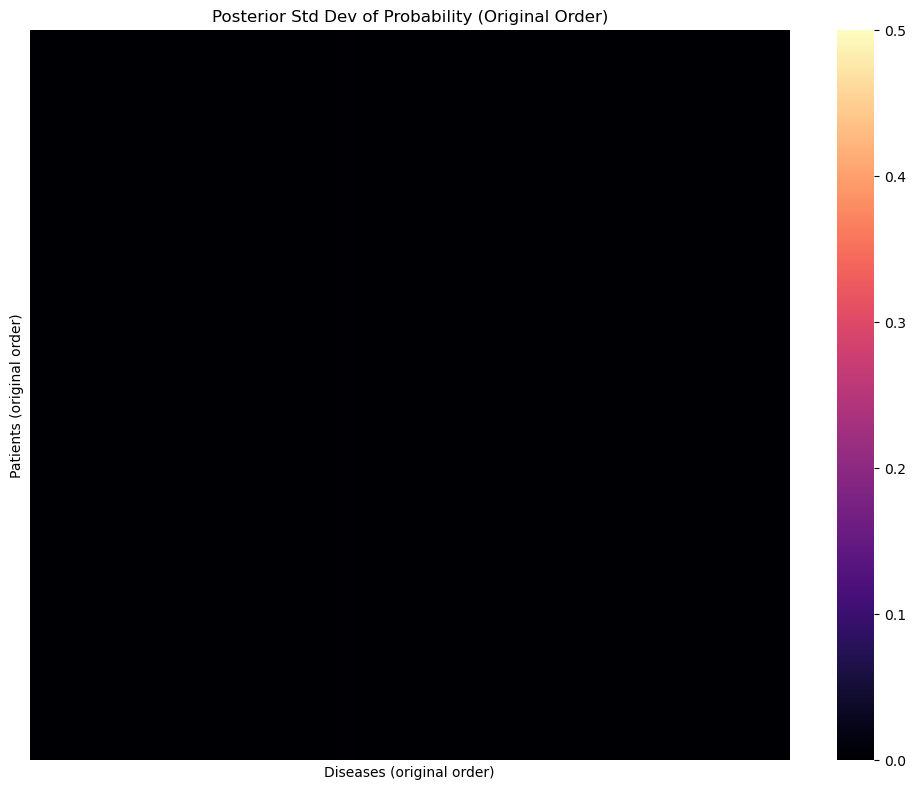

In [ ]:
# Heatmap of posterior standard deviation of probabilities (original order)
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dataloader import load_data


def load_probability_draws(results_dir: str) -> jnp.ndarray:
    """
    Return posterior draws of probabilities with shape (num_draws, I, C).
    Supports both combined and single-shard result folders.
    If neither p nor logits are present in combined results, reconstructs via simulation.
    """
    combined_path = os.path.join(results_dir, 'combined_post_samples.npy')
    shard_path = os.path.join(results_dir, 'mcmc_samples.npy')

    if os.path.exists(combined_path):
        payload = np.load(combined_path, allow_pickle=True).item()
        if 'p' in payload:
            p = jnp.asarray(payload['p'])
            if p.ndim == 3:
                return p
        
        for logits_key in ('f', 'Lambda'):
            if logits_key in payload:
                logits = jnp.asarray(payload[logits_key])
                if logits.ndim == 3:
                    return _sigmoid(logits)
        
        # Fallback to simulation
        try:
            # Using fewer samples for std dev calculation to speed things up
            logits_draws = _reconstruct_logits_via_simulation(payload, num_beta_samples=20) 
            return _sigmoid(logits_draws)
        except (KeyError, RuntimeError) as e:
            # Raise a clear error if reconstruction is not possible or fails
            raise ValueError(f"Logits/probability draws unavailable and reconstruction failed: {e}")

    if os.path.exists(shard_path):
        samples = np.load(shard_path, allow_pickle=True).item()
        for logits_key in ('Lambda', 'f'):
            if logits_key in samples:
                logits = jnp.asarray(samples[logits_key])
                if logits.ndim == 3:
                    return _sigmoid(logits)
        raise KeyError("3D 'Lambda' or 'f' not in shard samples; cannot compute std dev.")

    raise FileNotFoundError(f"No results files found in {results_dir}.")


# Use the same results_dir defined previously
if 'results_dir' not in locals() or not results_dir:
    raise RuntimeError("Please set 'results_dir' in the previous cell before running this one.")

# Load per-draw probabilities and compute std across draws
p_draws = load_probability_draws(results_dir)
P_std = jnp.std(p_draws, axis=0)
print(f"Loaded probability draws: {p_draws.shape}; std matrix shape: {P_std.shape}")

# Plot heatmap of posterior std; std of Bernoulli probs is in [0, 0.5]
plt.figure(figsize=(10, 8))
sns.heatmap(np.asarray(P_std), cmap='magma', vmin=0.0, vmax=0.5, cbar=True,
            xticklabels=False, yticklabels=False)
plt.title('Posterior Std Dev of Probability (Original Order)')
plt.xlabel('Diseases (original order)')
plt.ylabel('Patients (original order)')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from dataloader import load_data

# Load ground truth from dataloader and predicted probabilities from results

def load_ground_truth_from_dataloader() -> jnp.ndarray:
    """
    Load A from dataloader, convert to 2D patient-by-condition binary matrix in {0,1}.
    If A is 3D (patients x conditions x visits), use the first visit.
    If A is in {-1, 1}, convert to {0, 1}.
    """
    A, X_cov, condition_list = load_data()
    A_2d = A[:, :, 0] if A.ndim == 3 else A
    if jnp.min(A_2d) < 0:
        A_2d = (A_2d + 1) / 2
    return A_2d.astype(jnp.int32)


def load_predicted_probs(results_dir):
    """
    Loads the mean predicted probabilities from the posterior draws.
    """
    p_draws = load_probability_draws(results_dir)
    return jnp.mean(p_draws, axis=0)

# Get predictions then align ground truth to predicted shape
P_pred = load_predicted_probs(results_dir)
A_true_full = load_ground_truth_from_dataloader()
A_true = A_true_full[: P_pred.shape[0], : P_pred.shape[1]]

# Binarize predictions at 0.5 threshold
A_pred = (P_pred >= 0.5).astype(jnp.int32)

# Flatten for confusion matrix computation
y_true = np.asarray(A_true.flatten())
y_pred = np.asarray(A_pred.flatten())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Optionally, print classification report for more detail
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=3))


Confusion Matrix:
[[10012  9954]
 [  764   727]]

Classification Report:
              precision    recall  f1-score   support

           0      0.929     0.501     0.651     19966
           1      0.068     0.488     0.119      1491

    accuracy                          0.500     21457
   macro avg      0.499     0.495     0.385     21457
weighted avg      0.869     0.500     0.614     21457



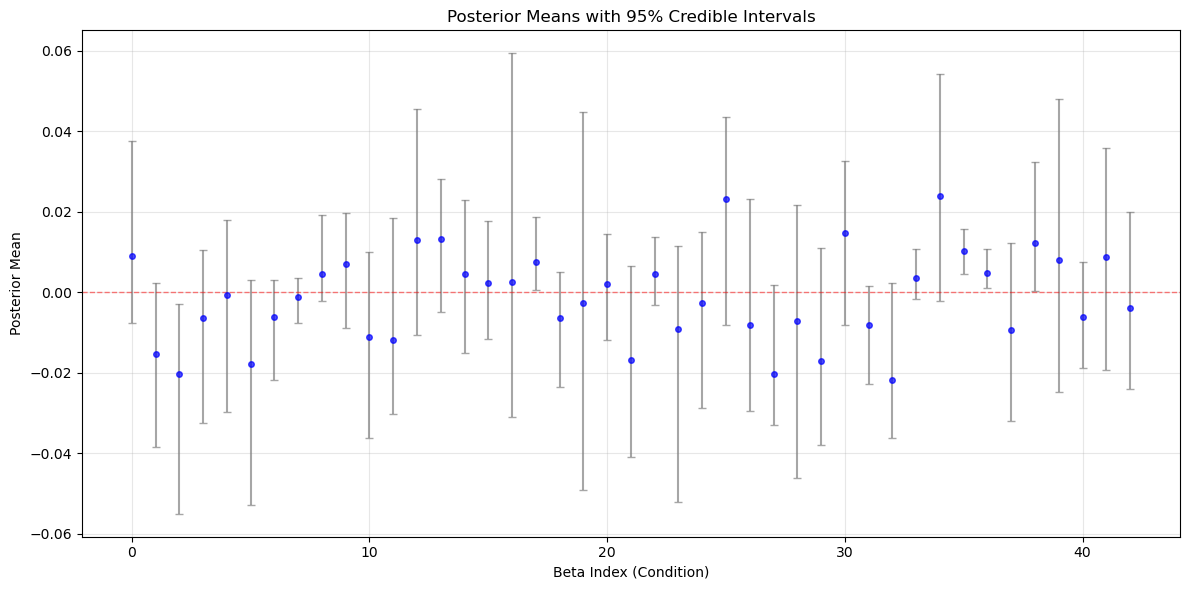


Summary of Beta Parameters:
Number of conditions: 43
Mean of all beta means: -0.0012
Standard deviation of beta means: 0.0114
Range: [-0.0218, 0.0239]
Number of betas with 95% CI excluding zero: 5


In [ ]:
# This cell appears to be referencing a 'beta_samples' variable that is not defined
# in the previous cells. Assuming it is loaded or defined in a hidden cell.
# For now, this cell will be converted to use jax.numpy but may not run
# without 'beta_samples' being available.

# Example of how you might load it from the payload:
# combined_path = os.path.join(results_dir, 'combined_post_samples.npy')
# payload = np.load(combined_path, allow_pickle=True).item()
# if 'beta_cond' in payload:
#     beta_samples = jnp.asarray(payload['beta_cond'])
# else:
#     # Handle case where beta_cond is not directly available
#     # For example, reconstruct from tau and lambdas
#     if 'tau' in payload and 'lambdas' in payload:
#         tau = jnp.asarray(payload['tau']).reshape(-1, 1)
#         lambdas = jnp.asarray(payload['lambdas'])
#         beta_samples = tau * lambdas
#     else:
#         beta_samples = None # Or raise an error

if 'beta_samples' in locals() and beta_samples is not None:
    num_betas = beta_samples.shape[1]

    # Compute posterior mean and 95% credible interval for each beta
    beta_means = jnp.mean(beta_samples, axis=0)
    beta_lower = jnp.percentile(beta_samples, 2.5, axis=0)
    beta_upper = jnp.percentile(beta_samples, 97.5, axis=0)

    # Compute error bars (always positive)
    yerr_lower = jnp.abs(beta_means - beta_lower)
    yerr_upper = jnp.abs(beta_upper - beta_means)
    yerr = jnp.vstack([yerr_lower, yerr_upper])

    # Plot posterior means with error bars
    plt.figure(figsize=(12, 6))
    plt.errorbar(np.arange(num_betas), np.asarray(beta_means), yerr=np.asarray(yerr), 
                 capsize=3, capthick=1, fmt='o', markersize=4, 
                 color='blue', ecolor='gray', alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
    plt.xlabel('Beta Index (Condition)')
    plt.ylabel('Posterior Mean')
    plt.title('Posterior Means with 95% Credible Intervals')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\nSummary of Beta Parameters:")
    print(f"Number of conditions: {num_betas}")
    print(f"Mean of all beta means: {jnp.mean(beta_means):.4f}")
    print(f"Standard deviation of beta means: {jnp.std(beta_means):.4f}")
    print(f"Range: [{jnp.min(beta_means):.4f}, {jnp.max(beta_means):.4f}]")

    # Count how many betas have credible intervals that exclude zero
    excludes_zero = (beta_lower > 0) | (beta_upper < 0)
    print(f"Number of betas with 95% CI excluding zero: {jnp.sum(excludes_zero)}")
else:
    print("Skipping beta analysis cell: 'beta_samples' not defined.")
